In [4]:
df = pd.read_csv("control_vanilla_preprocessed.csv")
# df.describe() # nice for obtaining statistics over dataframe
p,s,w = np.bincount(df['Class'])
total = p + s + w
print('Examples:\n    Total: {}\n    P: {} ({:.2f}% of total)\n    S: {} ({:.2f}% of total)\n    W: {} ({:.2f}% of total)\n'.format(
    total, p, 100 * p / total,s,100 * s / total,w,100 * w / total))

Examples:
    Total: 8641
    P: 367 (4.25% of total)
    S: 3965 (45.89% of total)
    W: 4309 (49.87% of total)



In [6]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

# val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
# val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
# print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
# print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (6912,)
Test labels shape: (1729,)
Training features shape: (6912, 42)
Test features shape: (1729, 42)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'W distribution')

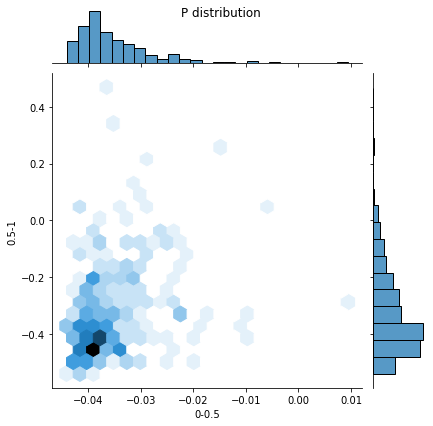

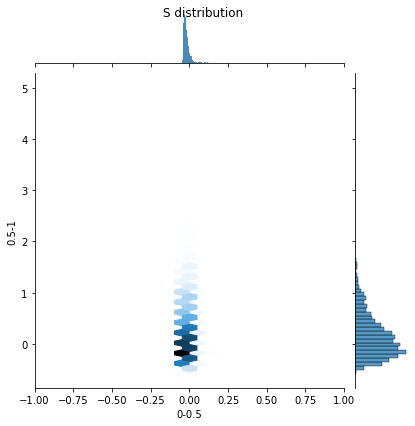

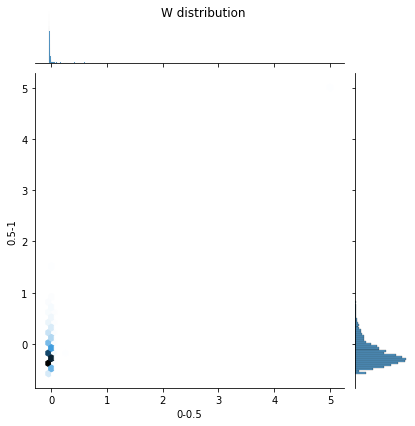

In [7]:

p_df = pd.DataFrame(train_features[ p_train_labels], columns=train_df.columns)
s_df = pd.DataFrame(train_features[ s_train_labels], columns=train_df.columns)
w_df = pd.DataFrame(train_features[ w_train_labels], columns=train_df.columns)


sns.jointplot(p_df['0-0.5'], p_df['0.5-1'],
              kind='hex')
plt.suptitle("P distribution")

sns.jointplot(s_df['0-0.5'], s_df['0.5-1'],
              kind='hex',xlim=(-1,1))
plt.suptitle("S distribution")

sns.jointplot(w_df['0-0.5'], w_df['0.5-1'],
              kind='hex')
plt.suptitle("W distribution")


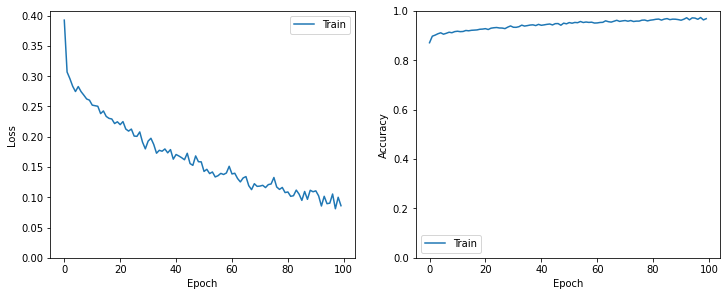

In [32]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    # plt.plot(history.epoch, history.history['val_'+metric],
    #          color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(baseline_history)

In [ ]:
df = pd.read_csv("control_vanilla_preprocessed.csv")
"""
Obtain the targets into variable "y" from the dataframe while deleting this
column from the dataframe in place.
"""
y = df.pop(df.columns[0]) # get targets

"""
A currently mysterious tensorflow command which forms a "dataset" from the input
feature set and targets.
  @X : features
  @y : targets
"""
#TODO: partition dataset into train, test, validation.
#
dataset = tf.data.Dataset.from_tensor_slices((df, y))
"""
We shuffle the dataset by the length of the dataframe. I think we do this so
that we can partition the dataset into train, test, validation and have each
target class equally represented. After the shuffle, we batch the dataset by 1.
I have heard that batching by larger sizes helps learning. How large?
"""
#TODO: test batch size hyperparameter
train_dataset = dataset.shuffle(len(df)).batch(1)
# I have done a lot of digging and it doesn't look like we can save this data, so we will have to run this pipeline each time.
"""
I saw this in a keras example. Our feature values are of type float64, so it
makes sense; however, I do not have a good justification for this line of code.
"""
tf.keras.backend.set_floatx('float64')
"""
Function to create model. This is a sequential model, meaning layers execute
one after the other. We have an input shape corresponding to the feature set,
one hidden layer with 10 neurons and a relu activation, then an output layer
with 3 neurons and a sigmoid activation function. We compute loss with
categorical crossentropy and optimize with adam, which I believe is something
about an adaptive learning rate. I do not know what the parameter from_logits
is about.
"""
# TODO : learn what adam optimizer is about
# TODO : learn what from_logits parameter is about
def get_compiled_model(n,output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
    keras.layers.Dense(n, activation='relu',input_shape=(train_features.shape[-1],)),
    keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='sigmoid',bias_initializer=output_bias)
    ])

    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model
"""
Call to fit model on dataset for a certain number of epochs. What are the other
parameters we can pass to this function? There is definitely learning rate and
validation data.
"""
# TODO: explore other parameters for model.fit
# histories = []
# from tqdm import tqdm
# offset = 5
# iterate_hl_neurons_for_n = 15
# for i in tqdm(range(iterate_hl_neurons_for_n)):
#   """
#   Call to obtain compiled model from get_compiled_model function.
#   """
#   model = get_compiled_model(offset+i)
#   histories.append(model.fit(train_dataset, epochs=20))
model = get_compiled_model(20)
model.fit(train_dataset,epochs=20)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/20
8641/8641 [==============================] - 10s 1ms/step - loss: 3.1640 - accuracy: 0.4844
Epoch 2/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8297 - accuracy: 0.5007
Epoch 3/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8628 - accuracy: 0.5020
Epoch 4/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8332 - accuracy: 0.4809
Epoch 5/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8436 - accuracy: 0.5019
Epoch 6/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8419 - accuracy: 0.4935
Epoch 7/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8392 - accuracy: 0.5044
Epoch 8/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8369 - accuracy: 0.4941
Epoch 9/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8467 - accuracy: 0.5012
Epoch 10/20
8641/8641 [==============================] - 10s 1ms/step - l


  7%|▋         | 1/15 [03:14<45:26, 194.77s/it]

Epoch 1/20
8641/8641 [==============================] - 10s 1ms/step - loss: 6.3250 - accuracy: 0.4917
Epoch 2/20
8641/8641 [==============================] - 10s 1ms/step - loss: 3.8656 - accuracy: 0.4942
Epoch 3/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.2422 - accuracy: 0.4851
Epoch 4/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8410 - accuracy: 0.5133
Epoch 5/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.6711 - accuracy: 0.7688
Epoch 6/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4478 - accuracy: 0.8620
Epoch 7/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4630 - accuracy: 0.8680
Epoch 8/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4386 - accuracy: 0.8676
Epoch 9/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4160 - accuracy: 0.8722
Epoch 10/20
8641/8641 [==============================] - 10s 1ms/step - l


 13%|█▎        | 2/15 [06:32<42:25, 195.77s/it]

Epoch 1/20
8641/8641 [==============================] - 10s 1ms/step - loss: 11.2553 - accuracy: 0.7115
Epoch 2/20
8641/8641 [==============================] - 10s 1ms/step - loss: 2.7844 - accuracy: 0.8056
Epoch 3/20
8641/8641 [==============================] - 11s 1ms/step - loss: 2.2145 - accuracy: 0.7888
Epoch 4/20
8641/8641 [==============================] - 10s 1ms/step - loss: 4.5470 - accuracy: 0.7965
Epoch 5/20
8641/8641 [==============================] - 10s 1ms/step - loss: 2.1682 - accuracy: 0.8126
Epoch 6/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.9319 - accuracy: 0.7831
Epoch 7/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.3153 - accuracy: 0.7973
Epoch 8/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.7147 - accuracy: 0.8070
Epoch 9/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.9945 - accuracy: 0.7379
Epoch 10/20
8641/8641 [==============================] - 10s 1ms/step - 


 20%|██        | 3/15 [09:56<39:37, 198.10s/it]

Epoch 1/20
8641/8641 [==============================] - 10s 1ms/step - loss: 7.7354 - accuracy: 0.6298
Epoch 2/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.3698 - accuracy: 0.6498
Epoch 3/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.9093 - accuracy: 0.8586
Epoch 4/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.5344 - accuracy: 0.8678
Epoch 5/20
8641/8641 [==============================] - 10s 1ms/step - loss: 2.0257 - accuracy: 0.8600
Epoch 6/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.9967 - accuracy: 0.8629
Epoch 7/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.3175 - accuracy: 0.8626
Epoch 8/20
8641/8641 [==============================] - 9s 1ms/step - loss: 0.8171 - accuracy: 0.8655
Epoch 9/20
8641/8641 [==============================] - 9s 1ms/step - loss: 0.5267 - accuracy: 0.8658
Epoch 10/20
8641/8641 [==============================] - 9s 1ms/step - loss


 27%|██▋       | 4/15 [13:11<36:09, 197.21s/it]

Epoch 1/20
8641/8641 [==============================] - 10s 1ms/step - loss: 16.7719 - accuracy: 0.6846
Epoch 2/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.0546 - accuracy: 0.8465
Epoch 3/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4412 - accuracy: 0.8718
Epoch 4/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4691 - accuracy: 0.8641
Epoch 5/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4148 - accuracy: 0.8756
Epoch 6/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4515 - accuracy: 0.8592
Epoch 7/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4959 - accuracy: 0.8667
Epoch 8/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4192 - accuracy: 0.8694
Epoch 9/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4864 - accuracy: 0.8690
Epoch 10/20
8641/8641 [==============================] - 10s 1ms/step - 


 33%|███▎      | 5/15 [16:30<32:58, 197.82s/it]

Epoch 1/20
8641/8641 [==============================] - 10s 1ms/step - loss: 7.0942 - accuracy: 0.7041
Epoch 2/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.5070 - accuracy: 0.7983
Epoch 3/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.8075 - accuracy: 0.8453
Epoch 4/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.8031 - accuracy: 0.8648
Epoch 5/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.5205 - accuracy: 0.8714
Epoch 6/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4929 - accuracy: 0.8805
Epoch 7/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.2503 - accuracy: 0.8729
Epoch 8/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.7133 - accuracy: 0.8813
Epoch 9/20
8641/8641 [==============================] - 10s 1ms/step - loss: 2.4322 - accuracy: 0.8733
Epoch 10/20
8641/8641 [==============================] - 10s 1ms/step - l


 40%|████      | 6/15 [19:55<29:59, 199.94s/it]

Epoch 1/20
8641/8641 [==============================] - 11s 1ms/step - loss: 6.1641 - accuracy: 0.7244
Epoch 2/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.4640 - accuracy: 0.8556
Epoch 3/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4561 - accuracy: 0.8655
Epoch 4/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.5540 - accuracy: 0.8553
Epoch 5/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.4036 - accuracy: 0.8710
Epoch 6/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4275 - accuracy: 0.8704
Epoch 7/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.4620 - accuracy: 0.8631
Epoch 8/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.4289 - accuracy: 0.8612
Epoch 9/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.4132 - accuracy: 0.8683
Epoch 10/20
8641/8641 [==============================] - 10s 1ms/step - l


 47%|████▋     | 7/15 [23:28<27:10, 203.85s/it]

Epoch 1/20
8641/8641 [==============================] - 11s 1ms/step - loss: 27.1502 - accuracy: 0.7186
Epoch 2/20
8641/8641 [==============================] - 10s 1ms/step - loss: 5.1536 - accuracy: 0.8082
Epoch 3/20
8641/8641 [==============================] - 10s 1ms/step - loss: 2.7115 - accuracy: 0.8213
Epoch 4/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.4126 - accuracy: 0.8255
Epoch 5/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.4654 - accuracy: 0.8329
Epoch 6/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.4099 - accuracy: 0.8438
Epoch 7/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.0595 - accuracy: 0.8488
Epoch 8/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.0318 - accuracy: 0.8497
Epoch 9/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.1519 - accuracy: 0.8666
Epoch 10/20
8641/8641 [==============================] - 11s 1ms/step - 


 53%|█████▎    | 8/15 [27:04<24:12, 207.51s/it]

Epoch 1/20
8641/8641 [==============================] - 12s 1ms/step - loss: 5.0464 - accuracy: 0.6987
Epoch 2/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.6970 - accuracy: 0.8623
Epoch 3/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.9413 - accuracy: 0.8660
Epoch 4/20
8641/8641 [==============================] - 10s 1ms/step - loss: 0.9760 - accuracy: 0.8758
Epoch 5/20
8641/8641 [==============================] - 11s 1ms/step - loss: 2.1071 - accuracy: 0.8794
Epoch 6/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.6090 - accuracy: 0.8846
Epoch 7/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.5110 - accuracy: 0.8795
Epoch 8/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.5327 - accuracy: 0.8757
Epoch 9/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.3979 - accuracy: 0.8752
Epoch 10/20
8641/8641 [==============================] - 11s 1ms/step - l


 60%|██████    | 9/15 [30:42<21:02, 210.48s/it]

Epoch 1/20
8641/8641 [==============================] - 11s 1ms/step - loss: 13.1394 - accuracy: 0.6755
Epoch 2/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.6092 - accuracy: 0.8577
Epoch 3/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.9048 - accuracy: 0.8716
Epoch 4/20
8641/8641 [==============================] - 11s 1ms/step - loss: 6.5730 - accuracy: 0.8581
Epoch 5/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.7054 - accuracy: 0.8702
Epoch 6/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.3005 - accuracy: 0.8744
Epoch 7/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.1519 - accuracy: 0.8738
Epoch 8/20
8641/8641 [==============================] - 12s 1ms/step - loss: 3.1657 - accuracy: 0.8749
Epoch 9/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.3647 - accuracy: 0.8808
Epoch 10/20
8641/8641 [==============================] - 11s 1ms/step - 


 67%|██████▋   | 10/15 [34:17<17:39, 211.84s/it]

Epoch 1/20
8641/8641 [==============================] - 11s 1ms/step - loss: 3.9684 - accuracy: 0.5856
Epoch 2/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.8242 - accuracy: 0.8075
Epoch 3/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.8193 - accuracy: 0.8550
Epoch 4/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.8304 - accuracy: 0.8672
Epoch 5/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.7079 - accuracy: 0.8259
Epoch 6/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.0264 - accuracy: 0.8750
Epoch 7/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.6341 - accuracy: 0.8724
Epoch 8/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.9093 - accuracy: 0.8685
Epoch 9/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.3132 - accuracy: 0.8750
Epoch 10/20
8641/8641 [==============================] - 11s 1ms/step - l


 73%|███████▎  | 11/15 [37:56<14:16, 214.24s/it]

Epoch 1/20
8641/8641 [==============================] - 11s 1ms/step - loss: 5.7238 - accuracy: 0.7170
Epoch 2/20
8641/8641 [==============================] - 11s 1ms/step - loss: 4.2020 - accuracy: 0.8241
Epoch 3/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.6769 - accuracy: 0.8505
Epoch 4/20
8641/8641 [==============================] - 11s 1ms/step - loss: 4.7370 - accuracy: 0.8492
Epoch 5/20
8641/8641 [==============================] - 10s 1ms/step - loss: 1.3264 - accuracy: 0.8630
Epoch 6/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.0147 - accuracy: 0.8620
Epoch 7/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.0144 - accuracy: 0.8608
Epoch 8/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.5306 - accuracy: 0.8637
Epoch 9/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.6879 - accuracy: 0.8694
Epoch 10/20
8641/8641 [==============================] - 11s 1ms/step - l


 80%|████████  | 12/15 [41:31<10:42, 214.21s/it]

Epoch 1/20
8641/8641 [==============================] - 11s 1ms/step - loss: 5.0608 - accuracy: 0.7378
Epoch 2/20
8641/8641 [==============================] - 10s 1ms/step - loss: 2.1637 - accuracy: 0.8297
Epoch 3/20
8641/8641 [==============================] - 11s 1ms/step - loss: 7.4889 - accuracy: 0.8477
Epoch 4/20
8641/8641 [==============================] - 11s 1ms/step - loss: 3.7128 - accuracy: 0.8287
Epoch 5/20
8641/8641 [==============================] - 11s 1ms/step - loss: 2.6292 - accuracy: 0.8506
Epoch 6/20
8641/8641 [==============================] - 11s 1ms/step - loss: 3.9620 - accuracy: 0.8384
Epoch 7/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.8902 - accuracy: 0.8563
Epoch 8/20
8641/8641 [==============================] - 12s 1ms/step - loss: 0.9840 - accuracy: 0.8657
Epoch 9/20
8641/8641 [==============================] - 11s 1ms/step - loss: 2.1479 - accuracy: 0.8622
Epoch 10/20
8641/8641 [==============================] - 11s 1ms/step - l


 87%|████████▋ | 13/15 [45:08<07:10, 215.10s/it]

Epoch 1/20
8641/8641 [==============================] - 11s 1ms/step - loss: 7.1625 - accuracy: 0.7219
Epoch 2/20
8641/8641 [==============================] - 11s 1ms/step - loss: 2.3275 - accuracy: 0.8539
Epoch 3/20
8641/8641 [==============================] - 11s 1ms/step - loss: 8.0826 - accuracy: 0.8705
Epoch 4/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.9815 - accuracy: 0.8716
Epoch 5/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.8984 - accuracy: 0.8732
Epoch 6/20
8641/8641 [==============================] - 11s 1ms/step - loss: 4.5554 - accuracy: 0.8772
Epoch 7/20
8641/8641 [==============================] - 11s 1ms/step - loss: 3.1204 - accuracy: 0.8799
Epoch 8/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.6032 - accuracy: 0.8745
Epoch 9/20
8641/8641 [==============================] - 11s 1ms/step - loss: 2.5456 - accuracy: 0.8769
Epoch 10/20
8641/8641 [==============================] - 11s 1ms/step - l


 93%|█████████▎| 14/15 [48:43<03:35, 215.24s/it]

Epoch 1/20
8641/8641 [==============================] - 11s 1ms/step - loss: 6.6885 - accuracy: 0.7092
Epoch 2/20
8641/8641 [==============================] - 11s 1ms/step - loss: 3.4236 - accuracy: 0.8052
Epoch 3/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.2714 - accuracy: 0.8598
Epoch 4/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.1897 - accuracy: 0.8672
Epoch 5/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.6433 - accuracy: 0.8750
Epoch 6/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.4911 - accuracy: 0.8714
Epoch 7/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.4365 - accuracy: 0.8765
Epoch 8/20
8641/8641 [==============================] - 11s 1ms/step - loss: 1.3206 - accuracy: 0.8728
Epoch 9/20
8641/8641 [==============================] - 11s 1ms/step - loss: 0.4909 - accuracy: 0.8695
Epoch 10/20
8641/8641 [==============================] - 11s 1ms/step - l


100%|██████████| 15/15 [52:18<00:00, 209.23s/it]


# Save Training Histories

In [ ]:
import pickle
for i,hist in enumerate(histories):
    model = hist.model
    params = hist.params
    hist = hist.history
    outfile = open("hist"+str(i), 'wb')
    pickle.dump(hist, outfile)
    outfile.close()
    model.save("model"+str(i)+".h5")
    outfile = open("params"+str(i), 'wb')
    pickle.dump(params, outfile)
    outfile.close()

FailedPreconditionError: ignored

# Load Training Histories

In [ ]:
histories_loaded = []
# TODO : How to remember the number of models saved?
for i in range(5):
  hist = {
      'model':[],
      'hist':[],
      'params':[]
  }
  hist['model'].append(keras.models.load_model("model"+str(i)+".h5"))
  hist['hist'].append(pickle.load(open("hist"+str(i), "rb")))
  hist['params'].append(pickle.load(open("params"+str(i), "rb")))
  histories_loaded.append(hist)

# Visualize Training Histories

Max Accuracy:  0.7554681171160745 Min Loss:  9.423585532491185
Number of Hidden Layer Neurons:  5


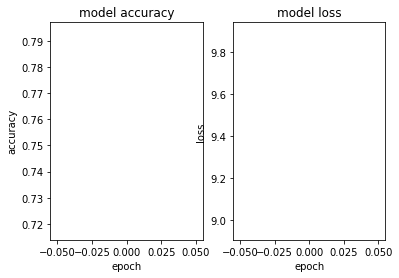

Max Accuracy:  0.7107973614165027 Min Loss:  3.8820540753105406
Number of Hidden Layer Neurons:  6


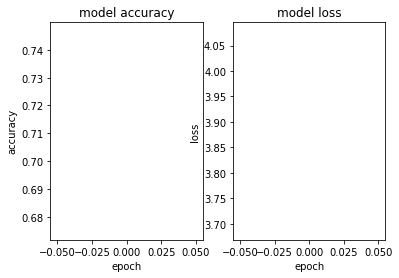

Max Accuracy:  0.7302395556069899 Min Loss:  2.8392225932967157
Number of Hidden Layer Neurons:  7


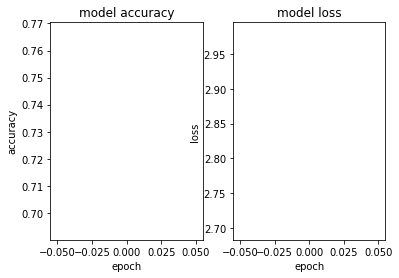

Max Accuracy:  0.7756046753847934 Min Loss:  5.961763520665806
Number of Hidden Layer Neurons:  8


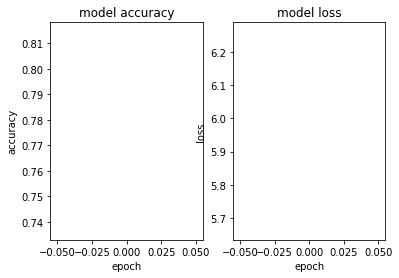

Max Accuracy:  0.668209697951626 Min Loss:  5.383028466879364
Number of Hidden Layer Neurons:  9


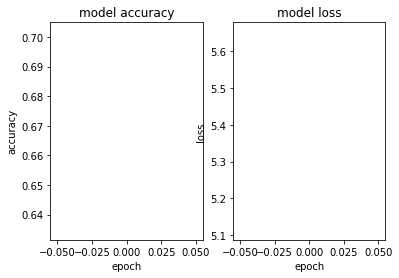

In [ ]:
for hist in histories_loaded:
  acc = hist['hist'][0]['accuracy']
  loss = hist['hist'][0]['loss']
  print("Max Accuracy: ",max(acc),"Min Loss: ",min(loss))
  print("Number of Hidden Layer Neurons: ",hist['model'][0].layers[0].output_shape[1])
  plt.subplot(1, 2, 1)
  plt.plot(acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
from google.colab import files
files.download("data.csv")
"""
TODO:
- train/test/val split (sklean package has a nice function to do this)
- extend underrepresented classes to be equal with class of highest representation
"""